<a href="https://colab.research.google.com/github/anish-sk/CS6910_Assignment1/blob/master/src/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade wandb
!wandb login 6746f968d95eb71e281d6c7772a0469574430408

     |████████████████████████████████| 2.0MB 7.6MB/s 
     |████████████████████████████████| 163kB 34.8MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
     |████████████████████████████████| 133kB 32.6MB/s 
     |████████████████████████████████| 71kB 12.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=89f2a18357485299c849f780ff78ee9b0c5e14ed4b048968b3fb0ed6a64596a4
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=16aee3ab2e1b5f02fe0e8c61e1ed5da7a5ccd0615ebbf37a624e8ff9e715dd8d
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
# Init wandb
import wandb

wandb.init(project="assignment1", entity="abisheks")

import numpy as np
from matplotlib import pyplot as plt
# Loading the fashion mnist dataset
from keras.datasets import fashion_mnist
# Setting seed value
np.random.seed(1)

# Load dataset (train data and test data)
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# Summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

wandb: Currently logged in as: abisheks (use `wandb login --relogin` to force relogin)


4423680/4422102 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [3]:
# Number of classes in the Fashion-MNIST dataset
N_CLASSES = np.unique(trainy).shape[0]    # 10 as known from the keras documentation

# Captions/Labels for the output classes present in Fashion-MNIST dataset
IMG_LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def getSampleImages(nClass, imgLabels, X, y, nSamples):
  '''
  The function takes few samples of each class from the dataset provided and passes it to the WANDB for it log the images

  Arguments :
    nClass -- Number of output classes in the dataset
    imgLabels -- List of labels for the output classes (numbered from 0 to nClass - 1)
    X -- The input data containing images in the form of matrices
    y -- The output data containing the class to which an input belongs
    nSamples -- Number of samples of each class to be taken. If that many samples not present in dataset, maximum number of samples present (from that class) will be taken

  Returns :
    -- None --
  '''

  # Initialise empty list to store the input data sampled from each class
  sampleImgsX = [[] for _ in range(nClass)]

  # Take 3 sample images from each class
  for i in range(y.shape[0]):
    if len(sampleImgsX[y[i]]) < nSamples :
      sampleImgsX[y[i]].append(X[i])


  # Getting a list of sample images of each class to be saved to wandb
  sampleImgsList = []
  for i in range(nClass):
    for j in range(3):
      sampleImgsList.append(wandb.Image(sampleImgsX[i][j], caption = imgLabels[i]))

  np.random.shuffle(sampleImgsList)
  wandb.log({"example" : sampleImgsList})


# Question 1 : Show 3 sample images from training set of downloaded Fashion-MNIST dataset in WANDB
getSampleImages(N_CLASSES, IMG_LABELS, trainX, trainy, 3)

In [4]:
def sigmoid(x):
  # Calculates the sigmoid function
  return np.exp(-np.logaddexp(0, -x))

def softmax(x):
  # Calculates the softmax function
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum()

def linear(W, X, b):
  # Calculates the linear function
  return W @ X + b

def grad_sigmoid(x):
  # Calculates the gradient of sigmoid function
  return sigmoid(x) * (1 - sigmoid(x))

def grad_tanh(x):
  # Calculates the gradient of tanh function
  return 1 - np.tanh(x)**2

def Softmax_CrossEntropy_grad(y_pred, y):
  # Calculates the gradient of the output layer with softmax activation and cross entropy loss
  # layer -- The dictionary for the output layer contianing info about it
  # y -- True output
  return -(y - y_pred)

In [5]:
trainX_reshaped = trainX.reshape((trainX.shape[1]*trainX.shape[2], trainX.shape[0]))
def initialize_network(n_L, preActFns_L, actFns_L, gradActFns_L, gradOutputFn):
  '''
  The function initializes the neural network and the appropriate parameters
  
  Arguments :
    n_L -- an array whose ith element represents the number of neurons in the ith layer (0 - Input Layer, last element - Output Layer)
    preActFns_L -- an array who ith element is the Pre Activation function of the (i+1)th layer of the neural network
    actFns_L -- an array who ith element is the Activation function of the (i+1)th layer of the neural network
    gradActFns_L -- an array who ith element is the gradient of the Activation function of the (i+1)th layer of the neural network
    gradOutputFn -- Function to calculate gradients wrt a_L (output layer) in back-propagation

  Returns :
    network -- the initialized network as an array of dictionaries for the hidden and output layers of the neural network
  '''

  L = len(n_L)-1

  assert(L >= 1)
  assert(len(preActFns_L) == L)
  assert(len(actFns_L) == L)

  network = list()
  for i in range(1,L+1):
    # Dictionary for each layer representing it's constituents
    layer = {'weights':np.random.randn(n_L[i], n_L[i-1])*0.1,    # Weight matrix for (i-1)th to ith layer transition
             'biases':np.zeros((n_L[i],1)),                       # Bias vector for (i-1)th to ith layer transition
             'pre_activation_fn':preActFns_L[i-1],                # Pre-activation function for neurons of the ith layer
             'activation_fn':actFns_L[i-1],                       # Activation function for neurons of the ith layer             
             'no_neurons':n_L[i],                                 # Number of neurons in ith layer
             'cache': []                                          # Array of cached pre-activation and activation output for each layer to be used in back-propagation (will be filled in forward-propagation)
            }
    network.append(layer)	
    if i < L:
      network[-1]['grad_activation_fn'] = gradActFns_L[i-1]       # Function calculating Gradient of the Activation function for the ith (hidden) layer
  
  network[-1]['grad_output_fn'] = gradOutputFn                    # Function calculating Gradient of the Output layer (Gradient of Loss function wrt a_L)

  return network


wandb.config.update({"n_hidden_layers": 3, "size_hidden_layer":32})    # Setting the hyperparameters in the wandb
L = wandb.config['n_hidden_layers']+1                                 # Number of hidden layerws + Output layer in the neural network
n_L = [wandb.config['size_hidden_layer']] * (L+1)                     # List of number of neurons in the neural network

n_L[0] = trainX.shape[1] * trainX.shape[2]
n_L[L] = N_CLASSES

pre_act_fns_L = [linear] * L                  # List of Pre-activation functions of the hidden layers and output layer
act_fns_L = [sigmoid] * (L-1) + [softmax]     # List of Activation functions of the hidden layers and output layer
grad_act_fns_L = [grad_sigmoid] * (L-1)       # List of Gradients of the Activation functions, of the hidden layers
grad_output_fn = Softmax_CrossEntropy_grad

network = initialize_network(n_L, pre_act_fns_L, act_fns_L, grad_act_fns_L, grad_output_fn)
print(network)

[{'weights': array([[-0.00881041,  0.08522393,  0.0677234 , ..., -0.07874835,
         0.01889887, -0.11595327],
       [ 0.03937244,  0.01440401,  0.01090145, ...,  0.10540162,
         0.0028068 , -0.06242023],
       [-0.0672467 , -0.0132852 ,  0.00814284, ..., -0.16260238,
         0.11895941, -0.12354781],
       ...,
       [-0.09160877,  0.0055915 , -0.19319459, ..., -0.07105937,
         0.04063715, -0.0435853 ],
       [ 0.25698507, -0.1390457 , -0.12580865, ...,  0.08983811,
         0.09303237,  0.03137708],
       [-0.01846599, -0.14477292,  0.10282756, ..., -0.01756312,
        -0.09916802, -0.0430083 ]]), 'biases': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [6]:
def pre_activation(H_prev, W, b, pre_activation_fn):
  # Calculates the pre-activation output and caches the required values. Returns the output and cache.
  #print(W.shape, H_prev.shape, b.shape)
  A = pre_activation_fn(W, H_prev, b)
  
  #print(A.shape)
  assert(A.shape[0] == W.shape[0])
  pre_act_cache = A   # Caching the pre-activation ouptut to be used in backpropagation

  return A, pre_act_cache

def feedforward_neuron(H_prev, W, b, activation_fn, pre_activation_fn):
  # Calculates the activation output (using the pre-activation function above) and caches the required values. Returns the output and cache.

  H_prev = H_prev.reshape((H_prev.shape[0], 1))
  A, pre_activation_cache = pre_activation(H_prev, W, b, pre_activation_fn)
  H = activation_fn(A)
  #print(H.shape, W.shape)
  assert (H.shape[0] == W.shape[0])
  H = H.reshape((H.shape[0],1))
  cache = (pre_activation_cache, H)   # Caching the pre-activation and activation output to use it in back-propagation

  return H, cache

In [7]:
def forward_propagation(network, x):
    """
    Implement forward propagation for the given neural network
    
    Arguments :
      network -- Given neural network (as an array of dictionaries)
      x -- Input data from the training set
    
    Returns :
      Output from the neural network
    """

    H = x                         # Initialising H to input
    L = len(network)              # Number of (hidden + output) layers in the neural network
    cache_prev = (x,x) 
    for l in range(0, L):
        H_prev = H 
        H, cache = feedforward_neuron(H_prev, network[l]['weights'], network[l]['biases'], network[l]['activation_fn'], network[l]['pre_activation_fn'])
        network[l]['cache'] = cache_prev
        cache_prev = cache
    
    assert(H.shape[0] == (network[L-1]['no_neurons']))
            
    return H

# HL = forward_propagation(trainX_reshaped, network)          # HL -- output from the neural network
# print(HL)

In [8]:
 def back_propagation(network, y, y_pred):
  """
    Implement backward propagation for the given neural network
    
    Arguments :
      network -- Given neural network (as an array of dictionaries)
      y -- True output corresponding to the training data input
    
    Returns :
      H -- Output from the neural network
  """

  L = len(network)

  # Gradients wrt output layer (a_L)
  #print(f"y_shape={y.shape}, network_s = {network[L-1]['cache'][1].shape}")
  grad_a_k_L = network[L-1]['grad_output_fn'](y_pred, y)

  # Initialising gradients to be calculated in the loop below
  grad_w_L = [np.zeros(2)] * L
  grad_b_L = [np.zeros(2)] * L
  grad_h_prev_L, grad_a_prev_L = 0, 0


  for k in range(L-1,-1,-1):
    # Gradients wrt Weights (W_k)
    #print("grad,network",k, grad_a_k_L.shape, network[k]['cache'][1].shape)

    grad_w_L[k] = grad_a_k_L @ network[k]['cache'][1].T

    # Gradients wrt Biases (b_k)
    grad_b_L[k] = grad_a_k_L

    # Gradients wrt hidden layer
    # Gradients wrt h_(k-1)
    grad_h_prev_L = network[k]['weights'].T @ grad_a_k_L

    # Gradients wrt a_(k-1)
    if(k > 0):
      #print(network[k-1]['grad_activation_fn'])
      #print(network[k]['cache'][0])
      grad_act_fn_prev = (network[k-1]['grad_activation_fn'])(network[k]['cache'][0])
      #grad_act_fn_prev = grad_sigmoid(network[k-1]['cache'][0])
      grad_a_prev_L = grad_h_prev_L * grad_act_fn_prev

    grad_a_k_L = grad_a_prev_L

  return grad_w_L, grad_b_L

In [9]:
def CrossEntropy_loss(y_pred, y_true):
  return -(y_true * np.log(y_pred)).sum()

def SquaredError(y_pred, y_true):
  return ((y_true - y_pred) ** 2).sum()



  0%|          | 1/300 [00:22<1:54:29, 22.98s/it]

138563.21534213546



  1%|          | 2/300 [00:45<1:53:49, 22.92s/it]

138209.69475064846



  1%|          | 3/300 [01:09<1:54:39, 23.16s/it]

138165.29161528384



  1%|▏         | 4/300 [01:32<1:54:20, 23.18s/it]

138208.82817847645



  2%|▏         | 5/300 [01:55<1:53:31, 23.09s/it]

138164.18080024305



  2%|▏         | 6/300 [02:18<1:53:13, 23.11s/it]

138208.14238927996



  2%|▏         | 7/300 [02:41<1:52:26, 23.03s/it]

138163.59745051613



  3%|▎         | 8/300 [03:04<1:52:01, 23.02s/it]

138207.17233056267



  3%|▎         | 9/300 [03:27<1:51:45, 23.04s/it]

138162.2589378174



  3%|▎         | 10/300 [03:51<1:52:30, 23.28s/it]

138206.0241261949



  4%|▎         | 11/300 [04:14<1:51:16, 23.10s/it]

138161.99854940144



  4%|▍         | 12/300 [04:37<1:51:17, 23.19s/it]

138204.56825552872



  4%|▍         | 13/300 [05:00<1:50:31, 23.11s/it]

138161.49513691512



  5%|▍         | 14/300 [05:23<1:49:47, 23.03s/it]

138203.6100706877



  5%|▌         | 15/300 [05:46<1:49:06, 22.97s/it]

138159.45663780934



  5%|▌         | 16/300 [06:09<1:49:03, 23.04s/it]

138202.9059149898



  6%|▌         | 17/300 [06:32<1:48:14, 22.95s/it]

138159.2751061581



  6%|▌         | 18/300 [06:55<1:48:27, 23.08s/it]

138201.266675138



  6%|▋         | 19/300 [07:17<1:47:10, 22.89s/it]

138158.99026344635



  7%|▋         | 20/300 [07:40<1:46:46, 22.88s/it]

138200.36053632997



  7%|▋         | 21/300 [08:04<1:47:16, 23.07s/it]

138158.4411736079



  7%|▋         | 22/300 [08:27<1:47:07, 23.12s/it]

138199.35324025716



  8%|▊         | 23/300 [08:50<1:46:19, 23.03s/it]

138156.91367019434



  8%|▊         | 24/300 [09:13<1:45:27, 22.92s/it]

138198.80609185286



  8%|▊         | 25/300 [09:35<1:44:23, 22.78s/it]

138156.57520307094



  9%|▊         | 26/300 [09:58<1:44:34, 22.90s/it]

138197.41520483643



  9%|▉         | 27/300 [10:21<1:44:20, 22.93s/it]

138155.2620985723



  9%|▉         | 28/300 [10:44<1:43:12, 22.77s/it]

138195.91217770195



 10%|▉         | 29/300 [11:06<1:42:53, 22.78s/it]

138154.3166231592



 10%|█         | 30/300 [11:28<1:41:15, 22.50s/it]

138195.83408601015



 10%|█         | 31/300 [11:51<1:41:01, 22.53s/it]

138153.8616308682



 11%|█         | 32/300 [12:14<1:41:08, 22.64s/it]

138193.3123824727



 11%|█         | 33/300 [12:36<1:40:54, 22.67s/it]

138152.1428678125



 11%|█▏        | 34/300 [12:59<1:40:38, 22.70s/it]

138191.68970496708



 12%|█▏        | 35/300 [13:22<1:40:18, 22.71s/it]

138152.78153469102



 12%|█▏        | 36/300 [13:46<1:41:01, 22.96s/it]

138191.90164664554



 12%|█▏        | 37/300 [14:09<1:40:52, 23.01s/it]

138149.90044890955



 13%|█▎        | 38/300 [14:31<1:39:58, 22.90s/it]

138190.8831447265



 13%|█▎        | 39/300 [14:54<1:39:26, 22.86s/it]

138150.37741718662



 13%|█▎        | 40/300 [15:16<1:37:49, 22.58s/it]

138188.25651927028



 14%|█▎        | 41/300 [15:39<1:37:50, 22.67s/it]

138149.02935021278



 14%|█▍        | 42/300 [16:02<1:38:23, 22.88s/it]

138187.86841450658



 14%|█▍        | 43/300 [16:24<1:37:04, 22.66s/it]

138147.42032724078



 15%|█▍        | 44/300 [16:47<1:36:20, 22.58s/it]

138186.9426332478



 15%|█▌        | 45/300 [17:10<1:36:42, 22.75s/it]

138150.3911933411



 15%|█▌        | 46/300 [17:32<1:36:00, 22.68s/it]

138186.47014566435



 16%|█▌        | 47/300 [17:55<1:35:54, 22.74s/it]

138148.53694042805



 16%|█▌        | 48/300 [18:18<1:35:49, 22.81s/it]

138184.02605093335



 16%|█▋        | 49/300 [18:41<1:35:48, 22.90s/it]

138145.52922859098



 17%|█▋        | 50/300 [19:05<1:35:40, 22.96s/it]

138182.2302527382



 17%|█▋        | 51/300 [19:27<1:34:32, 22.78s/it]

138145.25749378675



 17%|█▋        | 52/300 [19:50<1:34:32, 22.87s/it]

138181.20644367795



 18%|█▊        | 53/300 [20:13<1:34:14, 22.89s/it]

138142.3729946859



 18%|█▊        | 54/300 [20:36<1:34:29, 23.05s/it]

138180.32643894592



 18%|█▊        | 55/300 [20:59<1:33:46, 22.97s/it]

138142.40074108948



 19%|█▊        | 56/300 [21:22<1:33:46, 23.06s/it]

138179.26555973478



 19%|█▉        | 57/300 [21:45<1:32:41, 22.89s/it]

138141.09208698466



 19%|█▉        | 58/300 [22:08<1:32:14, 22.87s/it]

138176.7941448356



 20%|█▉        | 59/300 [22:30<1:31:28, 22.78s/it]

138140.8899520694



 20%|██        | 60/300 [22:54<1:31:53, 22.97s/it]

138174.2200366562



 20%|██        | 61/300 [23:16<1:30:47, 22.79s/it]

138138.83076418893



 21%|██        | 62/300 [23:39<1:30:07, 22.72s/it]

138173.84680800984



 21%|██        | 63/300 [24:01<1:29:46, 22.73s/it]

138137.33240421902



 21%|██▏       | 64/300 [24:24<1:29:38, 22.79s/it]

138172.05567041624



 22%|██▏       | 65/300 [24:47<1:28:49, 22.68s/it]

138136.77782582788



 22%|██▏       | 66/300 [25:09<1:28:16, 22.63s/it]

138170.43002350122



 22%|██▏       | 67/300 [25:31<1:27:19, 22.49s/it]

138135.1110488343



 23%|██▎       | 68/300 [25:53<1:26:30, 22.37s/it]

138168.02985238394



 23%|██▎       | 69/300 [26:16<1:26:11, 22.39s/it]

138134.50670521948



 23%|██▎       | 70/300 [26:38<1:25:51, 22.40s/it]

138166.60967521815



 24%|██▎       | 71/300 [27:01<1:25:19, 22.36s/it]

138132.0591058243



 24%|██▍       | 72/300 [27:23<1:24:30, 22.24s/it]

138165.39103978474



 24%|██▍       | 73/300 [27:44<1:23:46, 22.14s/it]

138130.02537897346



 25%|██▍       | 74/300 [28:07<1:23:37, 22.20s/it]

138164.55142142717



 25%|██▌       | 75/300 [28:29<1:23:42, 22.32s/it]

138130.79910217592



 25%|██▌       | 76/300 [28:52<1:23:40, 22.41s/it]

138163.11372681573



 26%|██▌       | 77/300 [29:15<1:23:31, 22.47s/it]

138128.56737599566



 26%|██▌       | 78/300 [29:37<1:23:17, 22.51s/it]

138160.35943134615



 26%|██▋       | 79/300 [30:00<1:23:26, 22.65s/it]

138129.22759635872



 27%|██▋       | 80/300 [30:24<1:23:45, 22.84s/it]

138156.8800142449



 27%|██▋       | 81/300 [30:46<1:23:05, 22.77s/it]

138126.4805248252



 27%|██▋       | 82/300 [31:09<1:22:27, 22.70s/it]

138156.3495275197



 28%|██▊       | 83/300 [31:31<1:21:27, 22.52s/it]

138126.04767659027



 28%|██▊       | 84/300 [31:54<1:21:30, 22.64s/it]

138155.60959820793



 28%|██▊       | 85/300 [32:17<1:21:24, 22.72s/it]

138123.2553435284



 29%|██▊       | 86/300 [32:39<1:20:43, 22.63s/it]

138155.95871551783



 29%|██▉       | 87/300 [33:02<1:20:44, 22.74s/it]

138123.16035192105



 29%|██▉       | 88/300 [33:24<1:19:56, 22.62s/it]

138150.68496277404



 30%|██▉       | 89/300 [33:47<1:19:24, 22.58s/it]

138121.36213213953



 30%|███       | 90/300 [34:10<1:20:01, 22.86s/it]

138147.4306366945



 30%|███       | 91/300 [34:33<1:19:14, 22.75s/it]

138121.56015295003



 31%|███       | 92/300 [34:55<1:18:26, 22.63s/it]

138145.9899723094



 31%|███       | 93/300 [35:18<1:18:19, 22.71s/it]

138117.59506515667



 31%|███▏      | 94/300 [35:40<1:17:03, 22.45s/it]

138147.62899015687



 32%|███▏      | 95/300 [36:03<1:17:49, 22.78s/it]

138113.44722138482



 32%|███▏      | 96/300 [36:26<1:17:39, 22.84s/it]

138144.04685576927



 32%|███▏      | 97/300 [36:48<1:16:21, 22.57s/it]

138118.58563367318



 33%|███▎      | 98/300 [37:12<1:16:40, 22.78s/it]

138141.17225392687



 33%|███▎      | 99/300 [37:35<1:16:31, 22.84s/it]

138113.91146906652



 33%|███▎      | 100/300 [37:57<1:16:04, 22.82s/it]

138137.9572713656



 34%|███▎      | 101/300 [38:20<1:15:27, 22.75s/it]

138111.02711992295



 34%|███▍      | 102/300 [38:43<1:15:04, 22.75s/it]

138134.5078379635



 34%|███▍      | 103/300 [39:06<1:14:55, 22.82s/it]

138109.52632974766



 35%|███▍      | 104/300 [39:28<1:14:20, 22.76s/it]

138133.7083893924



 35%|███▌      | 105/300 [39:51<1:13:46, 22.70s/it]

138109.13177029794



 35%|███▌      | 106/300 [40:14<1:13:45, 22.81s/it]

138130.66581277753



 36%|███▌      | 107/300 [40:36<1:12:41, 22.60s/it]

138105.38548399147



 36%|███▌      | 108/300 [40:59<1:12:40, 22.71s/it]

138128.44389203543



 36%|███▋      | 109/300 [41:22<1:12:06, 22.65s/it]

138109.24342111722



 37%|███▋      | 110/300 [41:43<1:10:58, 22.42s/it]

138129.94538392522



 37%|███▋      | 111/300 [42:06<1:10:25, 22.36s/it]

138101.75646284022



 37%|███▋      | 112/300 [42:28<1:10:10, 22.40s/it]

138125.61967134665



 38%|███▊      | 113/300 [42:51<1:09:56, 22.44s/it]

138102.44290431257



 38%|███▊      | 114/300 [43:13<1:09:52, 22.54s/it]

138123.93698741187



 38%|███▊      | 115/300 [43:36<1:09:36, 22.58s/it]

138100.0966179207



 39%|███▊      | 116/300 [43:59<1:09:37, 22.71s/it]

138118.6981995562



 39%|███▉      | 117/300 [44:21<1:08:49, 22.56s/it]

138098.56740971276



 39%|███▉      | 118/300 [44:43<1:08:02, 22.43s/it]

138116.56780100943



 40%|███▉      | 119/300 [45:06<1:08:10, 22.60s/it]

138095.25019933833



 40%|████      | 120/300 [45:29<1:07:52, 22.63s/it]

138115.54889997497



 40%|████      | 121/300 [45:51<1:06:59, 22.46s/it]

138093.71464599375



 41%|████      | 122/300 [46:14<1:06:53, 22.55s/it]

138113.7341681568



 41%|████      | 123/300 [46:36<1:06:02, 22.39s/it]

138093.28109852213



 41%|████▏     | 124/300 [46:58<1:05:46, 22.42s/it]

138110.59059362076



 42%|████▏     | 125/300 [47:21<1:05:40, 22.52s/it]

138089.8727508126



 42%|████▏     | 126/300 [47:43<1:04:53, 22.37s/it]

138103.4762350616



 42%|████▏     | 127/300 [48:06<1:05:09, 22.60s/it]

138090.98819871715



 43%|████▎     | 128/300 [48:29<1:05:06, 22.71s/it]

138101.9564951415



 43%|████▎     | 129/300 [48:52<1:04:38, 22.68s/it]

138087.21010169186



 43%|████▎     | 130/300 [49:15<1:04:19, 22.70s/it]

138100.58752837242



 44%|████▎     | 131/300 [49:37<1:04:00, 22.72s/it]

138080.24619360536



 44%|████▍     | 132/300 [50:00<1:03:26, 22.66s/it]

138099.80793330487



 44%|████▍     | 133/300 [50:23<1:03:09, 22.69s/it]

138080.71301806124



 45%|████▍     | 134/300 [50:45<1:02:46, 22.69s/it]

138098.86562023847



 45%|████▌     | 135/300 [51:09<1:02:42, 22.80s/it]

138082.10050008824



 45%|████▌     | 136/300 [51:31<1:02:11, 22.76s/it]

138092.13290301623



 46%|████▌     | 137/300 [51:54<1:02:04, 22.85s/it]

138078.5084954018



 46%|████▌     | 138/300 [52:17<1:01:45, 22.88s/it]

138089.248408005



 46%|████▋     | 139/300 [52:40<1:01:08, 22.79s/it]

138076.9740722963



 47%|████▋     | 140/300 [53:03<1:00:53, 22.84s/it]

138085.1377569082



 47%|████▋     | 141/300 [53:25<1:00:24, 22.80s/it]

138074.63475692875



 47%|████▋     | 142/300 [53:48<1:00:07, 22.83s/it]

138079.70740269835



 48%|████▊     | 143/300 [54:12<1:00:04, 22.96s/it]

138074.02642161603



 48%|████▊     | 144/300 [54:35<59:50, 23.01s/it]  

138081.6110523156



 48%|████▊     | 145/300 [54:58<59:26, 23.01s/it]

138061.56125356344



 49%|████▊     | 146/300 [55:21<59:19, 23.11s/it]

138079.6341669858



 49%|████▉     | 147/300 [55:44<58:26, 22.92s/it]

138072.4541825482



 49%|████▉     | 148/300 [56:06<57:33, 22.72s/it]

138073.44085846195



 50%|████▉     | 149/300 [56:29<57:27, 22.83s/it]

138063.98916025163



 50%|█████     | 150/300 [56:52<57:09, 22.86s/it]

138070.37179888808



 50%|█████     | 151/300 [57:14<56:31, 22.76s/it]

138061.2513007844



 51%|█████     | 152/300 [57:37<56:16, 22.81s/it]

138064.79279389768



 51%|█████     | 153/300 [58:00<55:53, 22.82s/it]

138060.89942668722



 51%|█████▏    | 154/300 [58:23<55:18, 22.73s/it]

138067.18722405535



 52%|█████▏    | 155/300 [58:45<54:57, 22.74s/it]

138062.9328001434



 52%|█████▏    | 156/300 [59:08<54:36, 22.75s/it]

138066.89550229372



 52%|█████▏    | 157/300 [59:30<53:54, 22.62s/it]

138047.25161616324



 53%|█████▎    | 158/300 [59:54<53:48, 22.74s/it]

138068.07807679864



 53%|█████▎    | 159/300 [1:00:16<53:30, 22.77s/it]

138045.20319193363



 53%|█████▎    | 160/300 [1:00:40<53:24, 22.89s/it]

138060.95161257134



 54%|█████▎    | 161/300 [1:01:02<53:04, 22.91s/it]

138045.80626268138



 54%|█████▍    | 162/300 [1:01:25<52:38, 22.89s/it]

138053.19855634443



 54%|█████▍    | 163/300 [1:01:48<52:13, 22.87s/it]

138043.12229668326



 55%|█████▍    | 164/300 [1:02:11<51:56, 22.92s/it]

138058.4200301778



 55%|█████▌    | 165/300 [1:02:33<50:51, 22.61s/it]

138035.09959576442



 55%|█████▌    | 166/300 [1:02:55<50:18, 22.52s/it]

138043.92276652533



 56%|█████▌    | 167/300 [1:03:18<49:55, 22.52s/it]

138041.16899597892



 56%|█████▌    | 168/300 [1:03:40<49:33, 22.53s/it]

138036.88582326495



 56%|█████▋    | 169/300 [1:04:04<49:35, 22.71s/it]

138038.36979067675



 57%|█████▋    | 170/300 [1:04:26<49:09, 22.69s/it]

138039.79306420413



 57%|█████▋    | 171/300 [1:04:48<48:27, 22.54s/it]

138030.13333129164



 57%|█████▋    | 172/300 [1:05:11<48:12, 22.60s/it]

138030.79155122937



 58%|█████▊    | 173/300 [1:05:34<47:59, 22.67s/it]

138033.1373092845



 58%|█████▊    | 174/300 [1:05:56<47:15, 22.50s/it]

138035.14143887634



 58%|█████▊    | 175/300 [1:06:19<46:53, 22.51s/it]

138023.70019298172



 59%|█████▊    | 176/300 [1:06:41<46:29, 22.50s/it]

138036.00937302536



 59%|█████▉    | 177/300 [1:07:04<46:09, 22.51s/it]

138013.08662346023



 59%|█████▉    | 178/300 [1:07:27<45:59, 22.62s/it]

138034.18544261577



 60%|█████▉    | 179/300 [1:07:49<45:32, 22.58s/it]

138007.3483438369



 60%|██████    | 180/300 [1:08:12<45:17, 22.65s/it]

138023.52760814613



 60%|██████    | 181/300 [1:08:35<44:58, 22.67s/it]

138010.49275888182



 61%|██████    | 182/300 [1:08:58<45:05, 22.93s/it]

138018.3087533116



 61%|██████    | 183/300 [1:09:21<44:43, 22.94s/it]

138013.35794547375



 61%|██████▏   | 184/300 [1:09:44<44:23, 22.96s/it]

138011.32610073168



 62%|██████▏   | 185/300 [1:10:07<43:50, 22.88s/it]

138006.9027289133



 62%|██████▏   | 186/300 [1:10:29<43:09, 22.71s/it]

138013.52627197417



 62%|██████▏   | 187/300 [1:10:52<43:00, 22.84s/it]

138002.32016220232



 63%|██████▎   | 188/300 [1:11:14<42:20, 22.68s/it]

138009.72158680073



 63%|██████▎   | 189/300 [1:11:37<41:55, 22.66s/it]

137993.0644832607



 63%|██████▎   | 190/300 [1:12:00<41:49, 22.82s/it]

138010.82541996485



 64%|██████▎   | 191/300 [1:12:22<41:05, 22.62s/it]

138004.42978642025



 64%|██████▍   | 192/300 [1:12:45<40:50, 22.69s/it]

137993.8089667685



 64%|██████▍   | 193/300 [1:13:08<40:30, 22.72s/it]

137998.35284489



 65%|██████▍   | 194/300 [1:13:31<39:58, 22.63s/it]

138003.52573734394



 65%|██████▌   | 195/300 [1:13:53<39:29, 22.57s/it]

137986.10609154595



 65%|██████▌   | 196/300 [1:14:16<39:09, 22.59s/it]

137992.91217453487



 66%|██████▌   | 197/300 [1:14:38<38:43, 22.55s/it]

137986.62549990363



 66%|██████▌   | 198/300 [1:15:01<38:33, 22.69s/it]

137988.05472642783



 66%|██████▋   | 199/300 [1:15:23<37:58, 22.56s/it]

137984.6498336645



 67%|██████▋   | 200/300 [1:15:46<37:38, 22.59s/it]

137986.68836052905



 67%|██████▋   | 201/300 [1:16:09<37:23, 22.66s/it]

137989.99189926096



 67%|██████▋   | 202/300 [1:16:31<36:47, 22.52s/it]

137974.41793796714



 68%|██████▊   | 203/300 [1:16:52<35:47, 22.14s/it]

137977.44720882075



 68%|██████▊   | 204/300 [1:17:15<35:31, 22.21s/it]

137976.62723935046



 68%|██████▊   | 205/300 [1:17:38<35:30, 22.42s/it]

137967.83638025794



 69%|██████▊   | 206/300 [1:18:00<34:57, 22.32s/it]

137971.4335905254



 69%|██████▉   | 207/300 [1:18:22<34:38, 22.35s/it]

137958.76618064218



 69%|██████▉   | 208/300 [1:18:44<34:07, 22.26s/it]

137968.1156154612



 70%|██████▉   | 209/300 [1:19:07<33:58, 22.40s/it]

137950.58980902965



 70%|███████   | 210/300 [1:19:29<33:23, 22.27s/it]

137965.14341244346



 70%|███████   | 211/300 [1:19:51<33:12, 22.38s/it]

137957.9795574144



 71%|███████   | 212/300 [1:20:14<32:43, 22.32s/it]

137961.73490247413



 71%|███████   | 213/300 [1:20:36<32:24, 22.35s/it]

137951.86844021466



 71%|███████▏  | 214/300 [1:20:59<32:11, 22.45s/it]

137952.60635928577



 72%|███████▏  | 215/300 [1:21:21<31:48, 22.46s/it]

137940.2391939796



 72%|███████▏  | 216/300 [1:21:43<31:21, 22.40s/it]

137947.87753125755



 72%|███████▏  | 217/300 [1:22:06<31:11, 22.55s/it]

137947.0375382494



 73%|███████▎  | 218/300 [1:22:28<30:25, 22.26s/it]

137944.9207802437



 73%|███████▎  | 219/300 [1:22:50<30:09, 22.34s/it]

137937.4934285615



 73%|███████▎  | 220/300 [1:23:13<29:53, 22.42s/it]

137929.95260754786



 74%|███████▎  | 221/300 [1:23:35<29:32, 22.43s/it]

137970.54300789136



 74%|███████▍  | 222/300 [1:23:59<29:25, 22.63s/it]

137932.75730593552



 74%|███████▍  | 223/300 [1:24:21<28:55, 22.53s/it]

137926.0369153089



 75%|███████▍  | 224/300 [1:24:44<28:46, 22.71s/it]

137936.67625515015



 75%|███████▌  | 225/300 [1:25:07<28:20, 22.68s/it]

137928.4962318684



 75%|███████▌  | 226/300 [1:25:29<27:54, 22.63s/it]

137927.16750797146



 76%|███████▌  | 227/300 [1:25:52<27:38, 22.72s/it]

137923.37274505483



 76%|███████▌  | 228/300 [1:26:15<27:12, 22.67s/it]

137921.6411702578



 76%|███████▋  | 229/300 [1:26:37<26:43, 22.58s/it]

137935.1417477881



 77%|███████▋  | 230/300 [1:27:00<26:19, 22.57s/it]

137912.43448542



 77%|███████▋  | 231/300 [1:27:22<25:46, 22.41s/it]

137906.5911755309



 77%|███████▋  | 232/300 [1:27:44<25:22, 22.38s/it]

137921.23001186998



 78%|███████▊  | 233/300 [1:28:06<24:53, 22.30s/it]

137918.23316651248



 78%|███████▊  | 234/300 [1:28:28<24:24, 22.19s/it]

137894.52403189588



 78%|███████▊  | 235/300 [1:28:50<24:02, 22.19s/it]

137911.233390874



 79%|███████▊  | 236/300 [1:29:13<23:56, 22.45s/it]

137893.3403444403



 79%|███████▉  | 237/300 [1:29:35<23:15, 22.16s/it]

137913.48805301348



 79%|███████▉  | 238/300 [1:29:57<23:05, 22.35s/it]

137899.51642336074



 80%|███████▉  | 239/300 [1:30:20<22:46, 22.41s/it]

137893.28037573842



 80%|████████  | 240/300 [1:30:42<22:13, 22.23s/it]

137889.46579778878



 80%|████████  | 241/300 [1:31:04<21:45, 22.12s/it]

137907.4318875128



 81%|████████  | 242/300 [1:31:26<21:32, 22.28s/it]

137879.1449184434



 81%|████████  | 243/300 [1:31:49<21:08, 22.26s/it]

137885.8530199248



 81%|████████▏ | 244/300 [1:32:11<20:56, 22.43s/it]

137875.39248174243



 82%|████████▏ | 245/300 [1:32:34<20:36, 22.48s/it]

137884.28490156718



 82%|████████▏ | 246/300 [1:32:56<20:05, 22.33s/it]

137877.28122231367



 82%|████████▏ | 247/300 [1:33:18<19:42, 22.31s/it]

137870.48498934062



 83%|████████▎ | 248/300 [1:33:40<19:18, 22.28s/it]

137862.01265058786



 83%|████████▎ | 249/300 [1:34:03<18:56, 22.28s/it]

137892.75825425374



 83%|████████▎ | 250/300 [1:34:25<18:37, 22.35s/it]

137864.5376100821



 84%|████████▎ | 251/300 [1:34:47<18:13, 22.32s/it]

137875.98473479087



 84%|████████▍ | 252/300 [1:35:10<17:51, 22.32s/it]

137859.5256592851



 84%|████████▍ | 253/300 [1:35:32<17:26, 22.27s/it]

137856.84140386872



 85%|████████▍ | 254/300 [1:35:54<17:06, 22.31s/it]

137858.93698486933



 85%|████████▌ | 255/300 [1:36:17<16:44, 22.31s/it]

137847.61716574288



 85%|████████▌ | 256/300 [1:36:38<16:12, 22.10s/it]

137860.01160865545



 86%|████████▌ | 257/300 [1:37:00<15:50, 22.10s/it]

137856.2588634491



 86%|████████▌ | 258/300 [1:37:23<15:37, 22.31s/it]

137851.8919935328



 86%|████████▋ | 259/300 [1:37:45<15:13, 22.29s/it]

137842.9927296395



 87%|████████▋ | 260/300 [1:38:08<14:52, 22.31s/it]

137838.81021147716



 87%|████████▋ | 261/300 [1:38:30<14:26, 22.23s/it]

137841.38598399475



 87%|████████▋ | 262/300 [1:38:51<13:56, 22.00s/it]

137823.73289830072



 88%|████████▊ | 263/300 [1:39:14<13:37, 22.10s/it]

137857.96518514247



 88%|████████▊ | 264/300 [1:39:36<13:16, 22.13s/it]

137832.6931002642



 88%|████████▊ | 265/300 [1:39:57<12:48, 21.96s/it]

137838.1051995956



 89%|████████▊ | 266/300 [1:40:20<12:35, 22.21s/it]

137822.4047264792



 89%|████████▉ | 267/300 [1:40:43<12:19, 22.40s/it]

137819.7539162006



 89%|████████▉ | 268/300 [1:41:05<11:50, 22.20s/it]

137819.28152847878



 90%|████████▉ | 269/300 [1:41:28<11:35, 22.44s/it]

137829.10172515252



 90%|█████████ | 270/300 [1:41:52<11:26, 22.89s/it]

137810.2699900915



 90%|█████████ | 271/300 [1:42:14<11:01, 22.82s/it]

137822.3434742348



 91%|█████████ | 272/300 [1:42:38<10:44, 23.03s/it]

137808.1703361495



 91%|█████████ | 273/300 [1:43:02<10:28, 23.28s/it]

137819.87272861545



 91%|█████████▏| 274/300 [1:43:26<10:09, 23.43s/it]

137789.49669974198



 92%|█████████▏| 275/300 [1:43:48<09:38, 23.16s/it]

137813.36558943507



 92%|█████████▏| 276/300 [1:44:11<09:12, 23.02s/it]

137801.62962270525



 92%|█████████▏| 277/300 [1:44:33<08:44, 22.81s/it]

137816.04065063372



 93%|█████████▎| 278/300 [1:44:55<08:17, 22.63s/it]

137794.29846357778



 93%|█████████▎| 279/300 [1:45:17<07:51, 22.46s/it]

137797.57339733955



 93%|█████████▎| 280/300 [1:45:39<07:25, 22.30s/it]

137793.963117228



 94%|█████████▎| 281/300 [1:46:01<07:02, 22.26s/it]

137779.02352802266



 94%|█████████▍| 282/300 [1:46:23<06:39, 22.18s/it]

137780.01136797



 94%|█████████▍| 283/300 [1:46:45<06:16, 22.13s/it]

137802.2329218646



 95%|█████████▍| 284/300 [1:47:08<05:54, 22.17s/it]

137779.4956235535



 95%|█████████▌| 285/300 [1:47:30<05:31, 22.09s/it]

137792.98380707533



 95%|█████████▌| 286/300 [1:47:52<05:09, 22.13s/it]

137788.25363819528



 96%|█████████▌| 287/300 [1:48:14<04:47, 22.10s/it]

137758.69972645328



 96%|█████████▌| 288/300 [1:48:37<04:28, 22.34s/it]

137772.18608961176



 96%|█████████▋| 289/300 [1:48:59<04:06, 22.38s/it]

137789.2361608996



 97%|█████████▋| 290/300 [1:49:22<03:43, 22.39s/it]

137760.4029725512



 97%|█████████▋| 291/300 [1:49:43<03:19, 22.17s/it]

137757.68430200536



 97%|█████████▋| 292/300 [1:50:06<02:58, 22.34s/it]

137753.5088243944



 98%|█████████▊| 293/300 [1:50:28<02:35, 22.26s/it]

137753.7331039619



 98%|█████████▊| 294/300 [1:50:50<02:13, 22.25s/it]

137762.87434115502



 98%|█████████▊| 295/300 [1:51:12<01:50, 22.12s/it]

137755.04526222395



 99%|█████████▊| 296/300 [1:51:34<01:28, 22.03s/it]

137749.48174214765



 99%|█████████▉| 297/300 [1:51:56<01:05, 21.98s/it]

137749.80723668603



 99%|█████████▉| 298/300 [1:52:18<00:44, 22.06s/it]

137755.0955946601



100%|█████████▉| 299/300 [1:52:41<00:22, 22.18s/it]

137706.62328203753



100%|██████████| 300/300 [1:53:03<00:00, 22.61s/it]

137740.09291828834


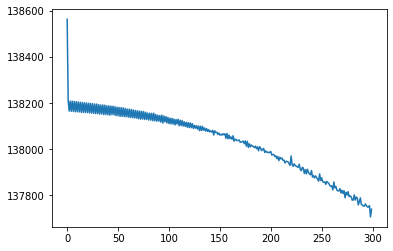

In [11]:
from tqdm import tqdm
loss_values = []
def vanilla_gradient_descent(X, Y, network, eta = 5e-2, max_epochs = 300, loss_fn = CrossEntropy_loss):
  """
    Trains the neural network using Vanilla/Batch Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith column is the input data corresponding to ith training example
      Y -- True output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      
    Returns :
      -- None --
  """
  
  L = len(network)

  for i in tqdm(range(max_epochs)):  
    dw, db = [0] * L, [0] * L
    for k in range(L):
      dw[k] = np.zeros_like(network[k]['weights'])
      db[k] = np.zeros_like(network[k]['biases'])

    curr_loss = 0
    for x,y in zip(X, Y):
      x = x.reshape((x.shape[0],  1))
      y = y.reshape((y.shape[0], 1))
      y_pred = forward_propagation(network, x)
      curr_loss += loss_fn(y_pred, y)
      grad_w_L, grad_b_L = back_propagation(network, y, y_pred)
      for k in range(L):
        #print(dw[k].shape, grad_w_L[k].shape)
        dw[k] += grad_w_L[k]
        db[k] += grad_b_L[k]
    
    loss_values.append(curr_loss)
    print(curr_loss)

    for k in range(L):
      m1 = np.linalg.norm(dw[k])
      if m1 > 0:
        dw[k] /= m1
      m2 = np.linalg.norm(db[k])
      if m2 > 0:
        db[k] /= m2
      network[k]['weights'] -= eta * dw[k]
      network[k]['biases'] -= eta * db[k]

trainy_onehot = []
for y in trainy:
  curr_y = [0]*N_CLASSES
  curr_y[y] = 1
  trainy_onehot.append(curr_y)

trainy_onehot = np.array(trainy_onehot)

vanilla_gradient_descent(trainX_reshaped.T, trainy_onehot, network)
plt.plot(loss_values)
plt.show()

In [ ]:
print("Hello")